In [1]:
import warnings

warnings.simplefilter("ignore")

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import RandomOverSampler

from plot_classification_report import plot_classification_report as pcf

In [2]:
# Import train data
df_train = pd.read_csv("train.csv")

df_train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
def wrangle_data(df):
    
    # Replace all NA values in the `previous_year_rating` with the most common rating: 3
    df["previous_year_rating"].fillna(3.0, inplace = True)
    
    # replace NA values in education column with most common degree
    df["education"].fillna("Bachelor's", inplace = True)
    
    # Split the strings, extract the second part of the split strings, convert the extracted part to an integer type
    df["region"] = df["region"].str.split('_').str[1].astype(int)    
    
    # Label Encoding: Encoding the degrees in an ordinal fashion
    df["education"] = df["education"].replace({"Master's & above": 2, "Bachelor's": 1,"Below Secondary":0 }).astype(int) 
    
    df = pd.get_dummies(df, columns=['department', "gender", "recruitment_channel"])    
    
    return df

In [4]:
df = wrangle_data(df_train)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   employee_id                   54808 non-null  int64  
 1   region                        54808 non-null  int32  
 2   education                     54808 non-null  int32  
 3   no_of_trainings               54808 non-null  int64  
 4   age                           54808 non-null  int64  
 5   previous_year_rating          54808 non-null  float64
 6   length_of_service             54808 non-null  int64  
 7   KPIs_met >80%                 54808 non-null  int64  
 8   awards_won?                   54808 non-null  int64  
 9   avg_training_score            54808 non-null  int64  
 10  is_promoted                   54808 non-null  int64  
 11  department_Analytics          54808 non-null  uint8  
 12  department_Finance            54808 non-null  uint8  
 13  d

In [6]:
df.head()

,employee_id,region,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,...,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,7,2,1,35,5.0,8,1,0,49,...,0,0,0,1,0,1,0,0,0,1
1,65141,22,1,1,30,5.0,4,0,0,60,...,1,0,0,0,0,0,1,1,0,0
2,7513,19,1,1,34,3.0,7,0,0,50,...,0,0,0,1,0,0,1,0,0,1
3,2542,23,1,2,39,1.0,10,0,0,50,...,0,0,0,1,0,0,1,1,0,0
4,48945,26,1,1,45,3.0,2,0,0,73,...,0,0,0,0,1,0,1,1,0,0


### Split Data

In [7]:
X = df.drop(columns = "is_promoted")
y = df["is_promoted"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (43846, 24)
X_test shape: (10962, 24)
y_train shape: (43846,)
y_test shape: (10962,)


### Resample

In [9]:
y_train.value_counts()

0    40086
1     3760
Name: is_promoted, dtype: int64

In [19]:
over_sampler = RandomOverSampler(random_state= 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)

### Build Model

In [15]:
clf = GradientBoostingClassifier(random_state= 42)

In [26]:
params = {
 "n_estimators": range(10,21,5),
 "max_depth" : range(40,51,10)
}
params

{'n_estimators': range(10, 21, 5), 'max_depth': range(40, 51, 10)}

In [27]:
model = GridSearchCV(
 clf,
 param_grid= params,
 cv = 5,
 n_jobs= -1, # give me all the power you have
 verbose = 1,
)
model

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(40, 51, 10),
                         'n_estimators': range(10, 21, 5)},
             verbose=1)

In [28]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(40, 51, 10),
                         'n_estimators': range(10, 21, 5)},
             verbose=1)

In [29]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.482619,0.533948,0.061835,0.006525,40,10,"{'max_depth': 40, 'n_estimators': 10}",0.969379,0.970065,0.966633,0.969565,0.970812,0.969291,0.001418,5
1,27.177093,0.177599,0.073410,0.004076,40,15,"{'max_depth': 40, 'n_estimators': 15}",0.969691,0.970315,0.966384,0.969627,0.970937,0.969391,0.001577,3
2,33.768955,1.210532,0.091665,0.003568,40,20,"{'max_depth': 40, 'n_estimators': 20}",0.969878,0.970253,0.967070,0.969502,0.970500,0.969441,0.001233,2
3,16.292232,0.231578,0.052460,0.000488,50,10,"{'max_depth': 50, 'n_estimators': 10}",0.968943,0.969816,0.967382,0.969627,0.970001,0.969154,0.000956,6
4,24.082105,0.337986,0.073005,0.003241,50,15,"{'max_depth': 50, 'n_estimators': 15}",0.969130,0.970440,0.967444,0.969939,0.970251,0.969441,0.001094,1
5,28.986988,3.201645,0.078908,0.012062,50,20,"{'max_depth': 50, 'n_estimators': 20}",0.969130,0.970377,0.967319,0.969752,0.970126,0.969341,0.001095,4


In [30]:
model.best_params_

{'max_depth': 50, 'n_estimators': 15}

In [31]:
y_train.value_counts(normalize= True).max()

0.9142453131414496

In [34]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9066


In [35]:
# Save model
with open("models/model-GBC.pkl", "wb") as f:
    pickle.dump(model, f)

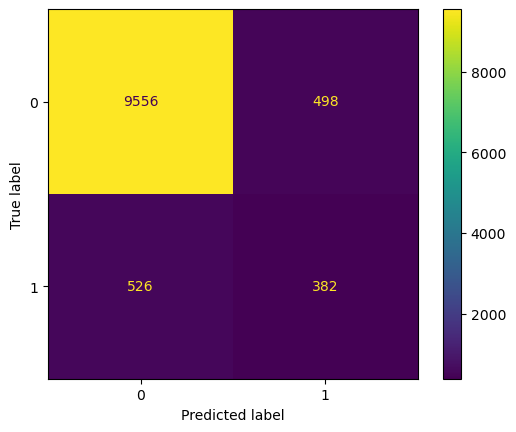

In [37]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

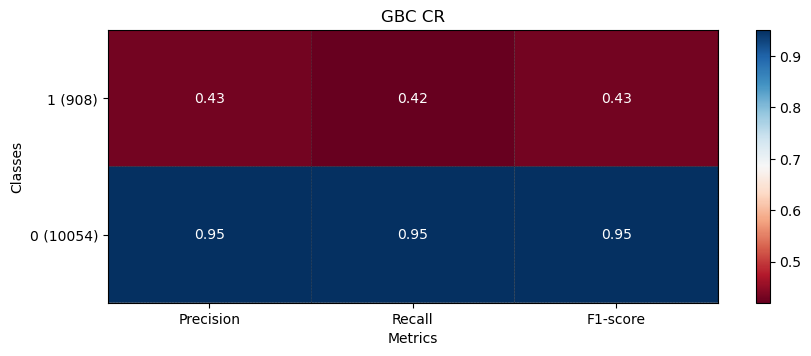

In [38]:
class_report_over = classification_report(y_test, model.predict(X_test))
pcf(class_report_over, "GBC CR");